#### 라이브러리 정의

In [1]:
import pandas as pd
import numpy as np

# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from shapely.geometry import Point
from folium.plugins import MarkerCluster

import os
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import webbrowser

### 경고(오류는 아님) 메시지 없애기
# - 사이킷런 버전에 따라 오류가 아니니 안내(경고)메시지가 자주 나타남
# - 안내(경고) 메시지 없이 실행할 수 있도록 처리
from sklearn import set_config
set_config(display="text")

# - 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

#### 화재 예측 범위 계산

In [2]:
# 1. Shapefile 불러오기
gdf_archive = gpd.read_file("./data/shp/fire_archive_SV-C2_591015.shp")
gdf_nrt = gpd.read_file("./data/shp/fire_nrt_SV-C2_591015.shp")
gdf = pd.concat([gdf_archive, gdf_nrt], ignore_index=True)
gdf = gdf.to_crs(epsg=4326)

# 2. australia_cleaned_wildfire 불러오기
cleaned_wildfire_df = pd.read_csv("./data/csv/australia_cleaned_wildfire.csv")
cleaned_wildfire_df['acq_date'] = pd.to_datetime(cleaned_wildfire_df[['year', 'month', 'day']])

# 3. GeoDataFrame 변환
geometry = [Point(lon, lat) for lon, lat in zip(cleaned_wildfire_df['longitude'], cleaned_wildfire_df['latitude'])]
geo_df = gpd.GeoDataFrame(cleaned_wildfire_df, geometry=geometry, crs="EPSG:4326")

# 4. 동적 버퍼 및 면적 계산
gdf = gdf.to_crs(epsg=32610)
gdf['buffer_radius'] = gdf['FRP'].apply(lambda x: min(500 + x * 10, 2000))  # FRP 비례 버퍼
gdf['geometry'] = [geom.buffer(radius) for geom, radius in zip(gdf['geometry'], gdf['buffer_radius'])]
gdf['predicted_area_km2'] = gdf.geometry.area / 1e6

# 5. 병합 데이터 준비 (burned_area_km2 제외)
shapefile_df = gdf[['LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'predicted_area_km2']]
shapefile_df['ACQ_DATE'] = pd.to_datetime(shapefile_df['ACQ_DATE'])
shapefile_df.columns = ['latitude', 'longitude', 'acq_date', 'predicted_area_km2']

# 6. 병합
merged_df = geo_df.merge(shapefile_df, on=['latitude', 'longitude', 'acq_date'], how='outer')
merged_df['predicted_area_km2'] = merged_df['predicted_area_km2'].fillna(0)

# 7. 결과 저장 및 확인
merged_df.to_csv("./data/australia_merged_fire.csv", index=False)
print(merged_df["predicted_area_km2"].describe())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18608\397915342.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shapefile_df['ACQ_DATE'] = pd.to_datetime(shapefile_df['ACQ_DATE'])


count    1.361256e+06
mean     1.221440e+00
std      1.384340e+00
min      0.000000e+00
25%      8.315680e-01
50%      9.034730e-01
75%      1.093313e+00
max      1.254619e+01
Name: predicted_area_km2, dtype: float64


In [3]:
wildfire_eda = pd.read_csv("./data/australia_merged_fire.csv")
wildfire_eda.info()

# 결측치 확인
print("결측치 개수 (처리 전):\n", wildfire_eda.isnull().sum())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18608\2029526414.py:1: DtypeWarning: Columns (22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  wildfire_eda = pd.read_csv("./data/australia_merged_fire.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361256 entries, 0 to 1361255
Data columns (total 29 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   latitude               1361256 non-null  float64
 1   longitude              1361256 non-null  float64
 2   brightness             1175962 non-null  float64
 3   bright_t31             1175962 non-null  float64
 4   frp                    1175962 non-null  float64
 5   T2M                    1175962 non-null  float64
 6   WS2M                   1175962 non-null  float64
 7   RH2M                   1175962 non-null  float64
 8   PRECTOTCORR            1175962 non-null  float64
 9   confidence_h           1175962 non-null  float64
 10  confidence_l           1175962 non-null  float64
 11  confidence_n           1175962 non-null  float64
 12  daynight_D             1175962 non-null  float64
 13  daynight_N             1175962 non-null  float64
 14  year              

In [4]:
# 결측치 처리 (결측치가 없더라도 명시적으로 처리)
# 현재는 결측치가 없으므로 이 단계는 스킵되지만, 코드에 포함시켜 안정성 확보
wildfire_eda = wildfire_eda.dropna()

# 데이터 타입 & 구조 확인
print("데이터 타입:\n", wildfire_eda.dtypes)

# 결측치 확인 (처리 후)
print("결측치 개수 (처리 후):\n", wildfire_eda.isnull().sum())

# 7. 결과 저장 및 확인
wildfire_eda.to_csv("./data/australia_merged_fire.csv", index=False)

데이터 타입:
 latitude                 float64
longitude                float64
brightness               float64
bright_t31               float64
frp                      float64
T2M                      float64
WS2M                     float64
RH2M                     float64
PRECTOTCORR              float64
confidence_h             float64
confidence_l             float64
confidence_n             float64
daynight_D               float64
daynight_N               float64
year                     float64
month                    float64
day                      float64
season                   float64
weekday                  float64
WS2M_RH2M_interaction    float64
high_temperature         float64
precipitation_flag       float64
T2M_binned_medium         object
T2M_binned_high           object
RH2M_binned_medium        object
RH2M_binned_high          object
acq_date                  object
geometry                  object
predicted_area_km2       float64
dtype: object
결측치 개수 (처리 후):
 lati

#### 시각화

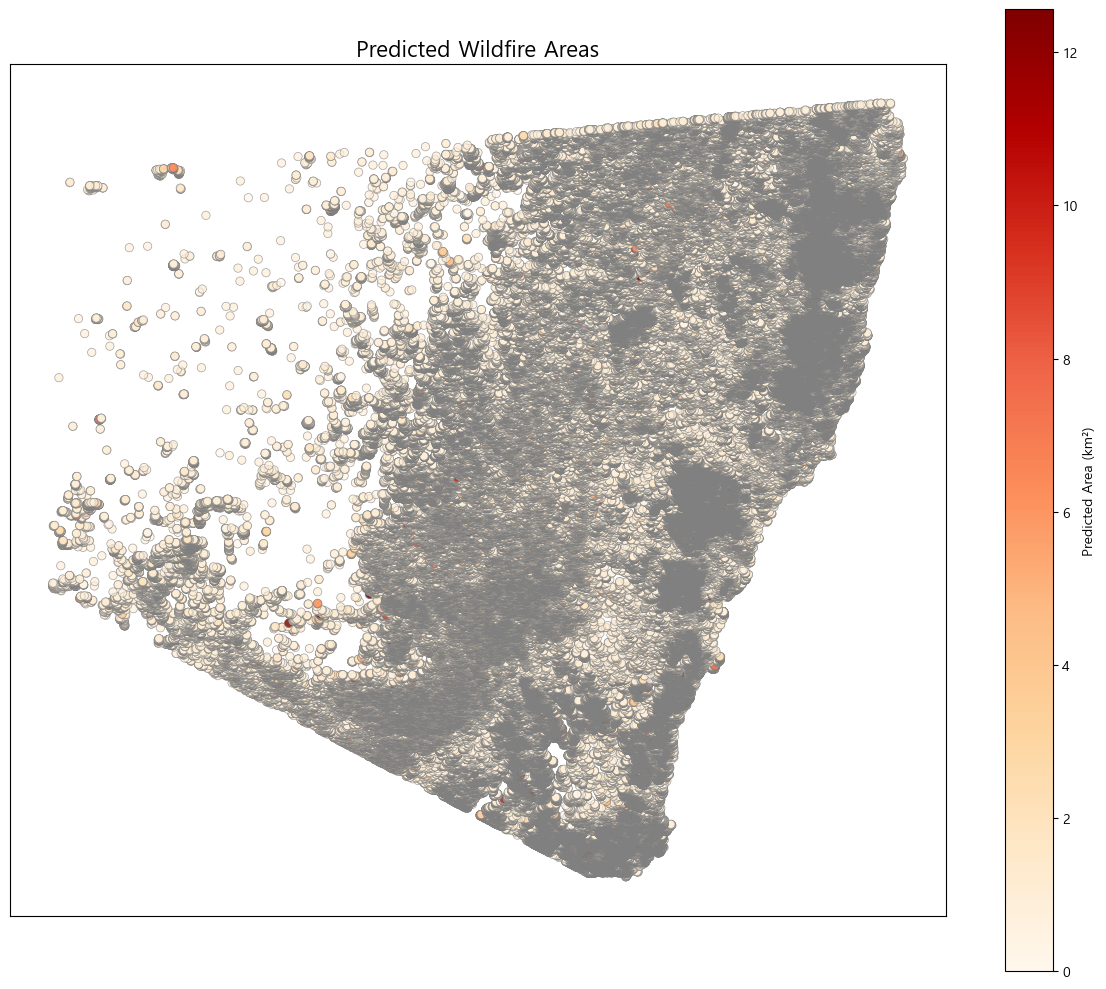

In [5]:
# 1. australia_merged_fire 로드 및 GeoDataFrame 변환
merged_df = pd.read_csv("./data/australia_merged_fire.csv")
# geometry를 Point 객체로 변환
merged_df['geometry'] = merged_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs="EPSG:4326")

# 2. 데이터 보정 (ValueError 방지)
# frp 값 보정: NaN 또는 inf를 0으로 대체
merged_gdf['frp'] = merged_gdf['frp'].replace([np.inf, -np.inf], np.nan).fillna(0)
# acq_date 처리
if 'acq_date' not in merged_gdf.columns:
    print("Warning: 'acq_date' not found, using placeholder")
    merged_gdf['acq_date'] = "Unknown"
else:
    merged_gdf['acq_date'] = pd.to_datetime(merged_gdf['acq_date'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

# 3. GeoPandas로 기본 지도 시각화 (검은색 테두리 조정)
fig, ax = plt.subplots(figsize=(12, 10))
merged_gdf.plot(
    ax=ax,
    column='predicted_area_km2',
    cmap='OrRd',
    edgecolor='gray',           # 검은색 대신 회색
    linewidth=0.5,              # 테두리 두께 줄임
    alpha=0.7,
    legend=True,
    vmin=0,
    vmax=12.566,
    legend_kwds={'label': "Predicted Area (km²)", 'orientation': "vertical"}
)
ax.set_title("Predicted Wildfire Areas", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [7]:
# 4. Folium으로 인터랙티브 지도 시각화 (당신의 HTML 스타일 유지)
# 샘플링 (10% 사용)
merged_gdf_sample = merged_gdf.sample(frac=0.1, random_state=42)

# 지도 생성 (당신의 스타일: 기본 타일, 캘리포니아 중심)
m = folium.Map(location=[-33.8688, 151.2093], zoom_start=6)  # 기본 타일 사용
marker_cluster = MarkerCluster().add_to(m)

# GeoJSON 변환 및 팝업 설정
geojson_data = merged_gdf_sample.to_json()
folium.GeoJson(
    geojson_data,
    name="Fire Detection",
    style_function=lambda x: {
        'fillColor': 'red',        # 빨간색 채우기 유지
        'color': 'gray',           # 검은색 대신 회색으로 변경
        'weight': 0.5,             # 테두리 두께 줄여 시각성 개선
        'fillOpacity': 0.6         # 약간 투명하게
    },
    popup=folium.features.GeoJsonPopup(
        fields=['predicted_area_km2', 'acq_date', 'frp'],
        aliases=['Predicted Area (km²)', 'Date', 'FRP'],
        localize=True,
        labels=True
    )
).add_to(marker_cluster)

# 지도 저장 및 열기
output_file = "./data/fire_map_geojson.html"
m.save(output_file)
file_path = os.path.abspath(output_file)
webbrowser.open(f"file://{file_path}")

print(f"Map saved as {output_file} and opened in browser")

Map saved as ./data/fire_map_geojson.html and opened in browser
